In [1]:
import pandas as pd

data = pd.read_csv("circles_binary_classification.csv")

# Getting the Feel of Data
- describe
- info
- head

In [2]:
data.describe()

,X1,X2,label
count,1000.000000,1000.000000,1000.00000
mean,-0.000448,-0.000804,0.50000
std,0.639837,0.641156,0.50025
min,-1.059502,-1.067768,0.00000
25%,-0.619251,-0.612176,0.00000
50%,0.008762,-0.003949,0.50000
75%,0.621933,0.624822,1.00000
max,1.033712,1.036004,1.00000


In [3]:
data.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      1000 non-null   float64
 1   X2      1000 non-null   float64
 2   label   1000 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 23.6 KB


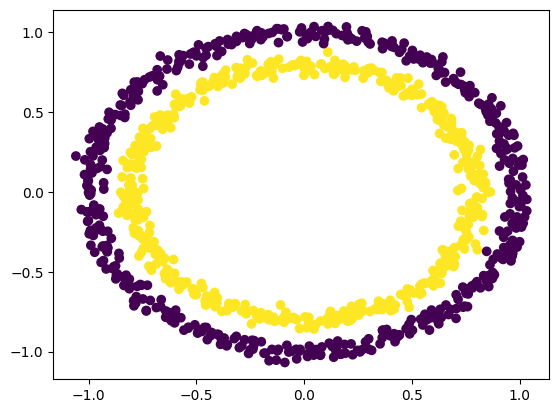

In [5]:
import matplotlib.pyplot as plt
plt.scatter(data['X1'], data['X2'], c=data['label'])

In [6]:
X = data[["X1", "X2"]].values
Y = data["label"].values

print(X.shape, Y.shape)

(1000, 2) (1000,)


In [7]:
import torch

X = torch.from_numpy(X).type(torch.float)
Y = torch.from_numpy(Y).type(torch.float)

In [8]:
print(X[:5], Y[:5])

tensor([[ 0.7542,  0.2315],
        [-0.7562,  0.1533],
        [-0.8154,  0.1733],
        [-0.3937,  0.6929],
        [ 0.4422, -0.8967]]) tensor([1., 1., 1., 1., 0.])


In [9]:
# Split data into train and test sets
# sklearn.model_selection
# train_test_split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    Y,
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

print(len(X_train), len(X_test), len(y_train), len(y_test))

800 200 800 200


In [10]:
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"

print(device)

cuda


In [11]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = nn.Linear(in_features=2, out_features=11)
        self.layer2 = nn.Linear(in_features=11, out_features=11)
        self.layer3 = nn.Linear(in_features=11, out_features=11)
        self.layer4 = nn.Linear(in_features=11, out_features=1)
        self.relu = nn.ReLU() # Adding Activation function

    def forward(self, x):
        return self.layer4(self.relu(self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))))

ClassificationModel = Model().to(device)

print(ClassificationModel)

Model(
  (layer1): Linear(in_features=2, out_features=11, bias=True)
  (layer2): Linear(in_features=11, out_features=11, bias=True)
  (layer3): Linear(in_features=11, out_features=11, bias=True)
  (layer4): Linear(in_features=11, out_features=1, bias=True)
  (relu): ReLU()
)


In [12]:
untrained_pred = ClassificationModel(X_test.to(device))

print(f"Length of predictions: {len(untrained_pred)}, Shape: {untrained_pred.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_pred[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[0.1299],
        [0.1367],
        [0.1489],
        [0.1290],
        [0.1571],
        [0.1543],
        [0.1593],
        [0.1581],
        [0.1486],
        [0.1378]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [13]:
#first 5 prediction
y_pred_labels = torch.round(torch.sigmoid(ClassificationModel(X_test.to(device))[:5]))

print(y_pred_labels)

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0', grad_fn=<RoundBackward0>)


In [14]:
#actual value
print(y_test[:5])

tensor([1., 0., 1., 0., 1.])


In [15]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=ClassificationModel.parameters(),
                            lr=0.2)

# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [16]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 1280

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

def train_and_test_loop(
    model: nn.Module,
    epochs: int,
    X_train: torch.Tensor,
    y_train: torch.Tensor,
    X_test: torch.Tensor,
    y_test: torch.Tensor,
    loss_fn: nn.Module,
    optimizer: torch.optim.Optimizer
):
    # lists
    loss_list = []
    acc_list = []
    test_losses = []
    test_acc_list = []



    # Build training and evaluation loop
    for epoch in range(epochs):
        ### Training
        model.train()

        # 1. Forward pass (model outputs raw logits)
        y_logits = model(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device
        y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls

        # 2. Calculate loss/accuracy
        # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
        #                y_train)
        loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                    y_train)
        acc = accuracy_fn(y_true=y_train,
                        y_pred=y_pred)

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backwards
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        ### Testing
        model.eval()
        with torch.inference_mode():
            # 1. Forward pass
            test_logits = model(X_test).squeeze()
            test_pred = torch.round(torch.sigmoid(test_logits))
            # 2. Caculate loss/accuracy
            test_loss = loss_fn(test_logits,
                                y_test)
            test_acc = accuracy_fn(y_true=y_test,
                                y_pred=test_pred)


        loss_list.append(loss.item())
        acc_list.append(acc)
        test_losses.append(test_loss.item())
        test_acc_list.append(test_acc)

        # Print out what's happening every 10 epochs
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

    return loss_list, acc_list, test_losses, test_acc_list

In [17]:
train_losses, acc_list, test_losses, test_acc = train_and_test_loop(
    model=ClassificationModel,
    epochs=epochs,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    loss_fn=loss_fn,
    optimizer=optimizer
)


Epoch: 0 | Loss: 0.69629, Accuracy: 50.00% | Test loss: 0.69536, Test acc: 50.00%
Epoch: 10 | Loss: 0.69384, Accuracy: 50.00% | Test loss: 0.69325, Test acc: 50.00%
Epoch: 20 | Loss: 0.69318, Accuracy: 50.00% | Test loss: 0.69272, Test acc: 50.00%
Epoch: 30 | Loss: 0.69292, Accuracy: 54.87% | Test loss: 0.69255, Test acc: 58.50%
Epoch: 40 | Loss: 0.69275, Accuracy: 51.12% | Test loss: 0.69245, Test acc: 55.00%
Epoch: 50 | Loss: 0.69262, Accuracy: 51.88% | Test loss: 0.69238, Test acc: 51.00%
Epoch: 60 | Loss: 0.69249, Accuracy: 52.25% | Test loss: 0.69231, Test acc: 51.50%
Epoch: 70 | Loss: 0.69237, Accuracy: 54.75% | Test loss: 0.69222, Test acc: 54.00%
Epoch: 80 | Loss: 0.69226, Accuracy: 61.38% | Test loss: 0.69212, Test acc: 59.50%
Epoch: 90 | Loss: 0.69214, Accuracy: 64.25% | Test loss: 0.69202, Test acc: 61.00%
Epoch: 100 | Loss: 0.69201, Accuracy: 64.88% | Test loss: 0.69192, Test acc: 64.00%
Epoch: 110 | Loss: 0.69188, Accuracy: 64.88% | Test loss: 0.69182, Test acc: 64.00%
Epo

# Helper function
Taken from the povided resources.

In [18]:
import numpy as np

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

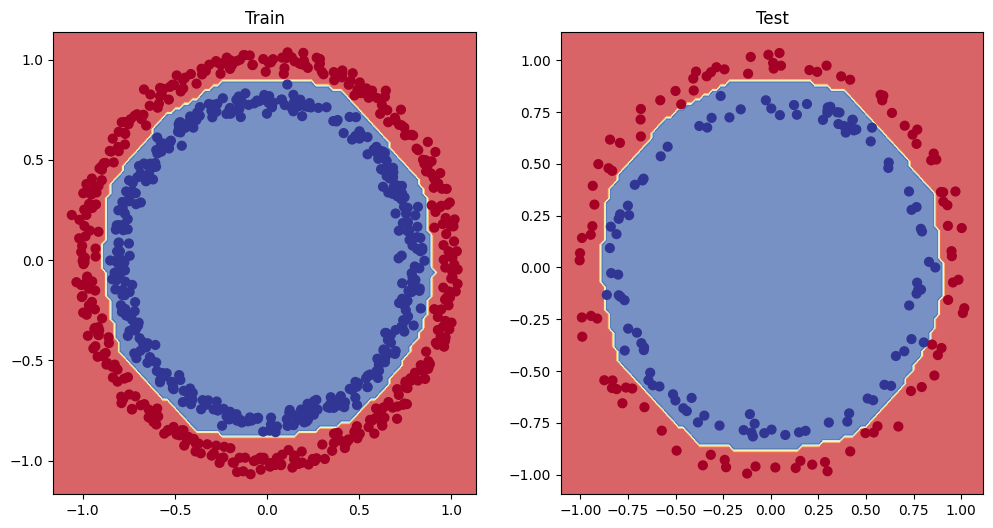

In [19]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(ClassificationModel, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(ClassificationModel, X_test, y_test)
